In [54]:
import re
import cnfg
import json
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, roc_curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import clone
from itertools import chain
from collections import Counter, defaultdict

%matplotlib inline
sns.set_style("whitegrid")
params = {'axes.labelsize': 14,
          'axes.labelweight': 'bold',
          'axes.titlesize': 16,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

## Background

Kiva is a site for crowdfunded microfinance. Kiva allows people to lend money on the internet to low-income entrepreneurs. Loans must be **funded within 30 days** of posting otherwise they become **expired**.

The goal of this project is to build a classifier which predicts which Kiva loans will be funded.

## Initialize Data from DB

In [2]:
config = cnfg.load(".metis_config")
engine = create_engine('postgresql://{}:{}@{}:5432/{}'.format(
            config['db_user'],
            config['db_pwd'],
            config['db_host'],
            'ubuntu'))

conn = engine.connect()
query = 'SELECT * FROM kiva_loan_view'
df = pd.read_sql_query(query, conn)

## Data Train/Test Split

Use stratified sampling to get training and test data from table `loan_view`:
- `X_train`, `X_test`
- `y_train`, `y_test`

Around 8% of loans 'expired' (positive class).

In [3]:
# Get training data X and labels y
y_col = 'status'
X_columns = df.columns.drop([y_col])
X = df.loc[:, X_columns]

# Expired Status = Positive Class (i.e. y=1)
y_status = df[y_col] 
y = y_status.map(lambda status: 1 if (status == 'expired') else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=55)

# Check if stratified K-Fold sampling worked correctly
train_data_count = y_train.shape[0]
test_data_count = y_test.shape[0]

print("""# Training points: {}, # Test points: {}
% Loans expired in training data: {}
% Loans expired in test data: {}""".format(
    train_data_count, test_data_count,
    y_train[y_train == 1].shape[0] * 100 / train_data_count,
    y_test[y_test == 1].shape[0] * 100 / test_data_count)
)

# Training points: 63551, # Test points: 21184
% Loans expired in training data: 8.053374455161995
% Loans expired in test data: 8.053247734138973


## Data Exploration

### Existing Features

Don't use features `funded_date`, `funded_amount`, and `lender_count` because these would cause data leakage.

In [4]:
X_train.columns.values

array(['id', 'name', 'funded_amount', 'funded_date',
       'planned_expiration_date', 'posted_date', 'sector', 'activity',
       'loan_amount', 'lender_count', 'country', 'country_code', 'town',
       'latitude', 'longitude', 'bonus_credit_eligibility', 'description',
       'use_text', 'tag_text', 'terms_disbursal_amount',
       'terms_disbursal_currency', 'terms_disbursal_date',
       'terms_loan_amount', 'terms_loss_liability_nonpayment',
       'terms_repayment_term', 'journal_totals_entries', 'borrower_count',
       'm_borrower_count', 'f_borrower_count', 'pic_borrower_count'], dtype=object)

### Data Distribution

Remove outliers where loan amount > $10000 and loan length > 100 months. 

In [5]:
X_train.describe()

,id,funded_amount,loan_amount,lender_count,latitude,longitude,terms_disbursal_amount,terms_loan_amount,terms_repayment_term,journal_totals_entries,borrower_count,m_borrower_count,f_borrower_count,pic_borrower_count
count,6.355100e+04,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,6.355100e+04,63551.000000,63551.000000,63551.0,63551.000000,63551.000000,63551.000000,63551.000000
mean,1.086020e+06,763.520244,819.767195,20.073516,10.658339,33.646768,1.189249e+06,819.767195,13.575270,0.0,1.980567,0.399569,1.580998,1.948577
std,3.079779e+04,1113.542627,1151.308639,26.982058,14.823680,80.499433,5.585610e+06,1151.308639,7.945217,0.0,3.200214,1.040144,2.891592,3.059185
min,1.017905e+06,0.000000,25.000000,0.000000,-30.000000,-172.616667,1.000000e+02,25.000000,2.000000,0.0,1.000000,0.000000,0.000000,1.000000
25%,1.057834e+06,250.000000,275.000000,7.000000,1.000000,-57.996389,5.500000e+03,275.000000,8.000000,0.0,1.000000,0.000000,1.000000,1.000000
50%,1.092222e+06,425.000000,475.000000,12.000000,13.000000,38.000000,2.000000e+04,475.000000,13.000000,0.0,1.000000,0.000000,1.000000,1.000000
75%,1.113756e+06,825.000000,925.000000,23.000000,13.833333,122.000000,1.000000e+05,925.000000,14.000000,0.0,1.000000,1.000000,1.000000,1.000000
max,1.140926e+06,50000.000000,50000.000000,1626.000000,49.783333,159.000000,1.300000e+08,50000.000000,145.000000,0.0,44.000000,28.000000,41.000000,44.000000


In [6]:
# Outliers
len(X_train[X_train.loan_amount > 10000]), len(X_train[X_train.terms_repayment_term > 100])

(15, 24)

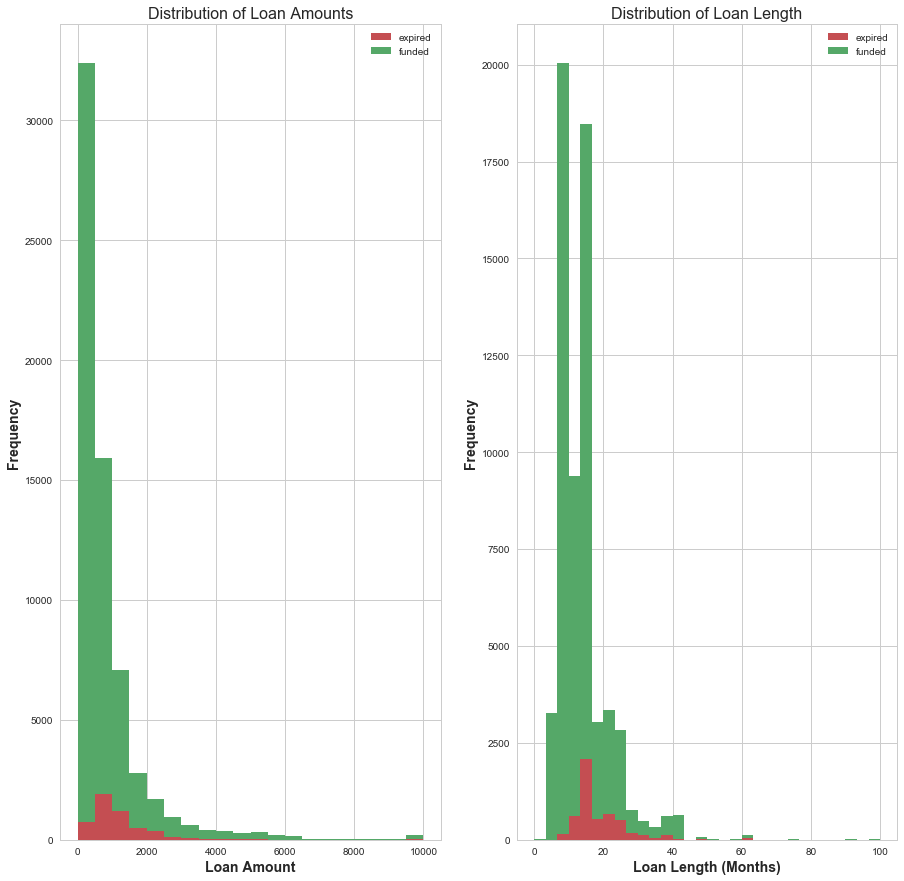

In [7]:
def initial_data_explore(data_expired, data_funded):
    """
    Plot frequencies vs features grouped by expired or funded status
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))

    # Loan Amounts
    pd.DataFrame({
        'expired': data_expired.loan_amount,
        'funded': data_funded.loan_amount
    }).plot.hist(ax=ax[0], stacked=True, bins=20,
                 color=['#c44e52', '#55a868'], range=(0,10000))

    ax[0].set_title('Distribution of Loan Amounts')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlabel('Loan Amount')

    # Loan Length (Repayment Term)
    pd.DataFrame({
        'expired': data_expired[~np.isnan(data_expired.repayment_term)].repayment_term,
        'funded': data_funded[~np.isnan(data_funded.repayment_term)].repayment_term
    }).plot.hist(ax=ax[1], stacked=True, bins=30, range=(0,100),
                 color=['#c44e52', '#55a868'])

    ax[1].set_title('Distribution of Loan Length')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xlabel('Loan Length (Months)')

train_status = pd.DataFrame({'loan_amount': X_train.loan_amount,
                             'repayment_term': X_train.terms_repayment_term,
                             'country': X_train.country,
                             'sector': X_train.sector, 
                             'activity': X_train.activity, 
                             'status': y_train})

train_expired = train_status.groupby('status').get_group(1)
train_funded = train_status.groupby('status').get_group(0)

initial_data_explore(train_expired, train_funded)

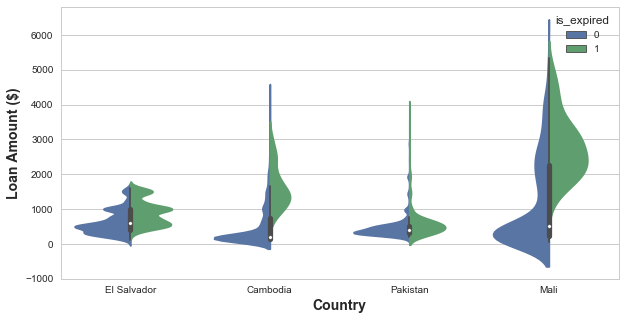

In [8]:
def plot_expiration_by_country():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    train_Xy = pd.concat([X_train, pd.DataFrame({'is_expired': y_train})], axis=1)
    train_Xy_country = train_Xy.loc[(train_Xy.country == 'Pakistan') | (train_Xy.country == 'Mali') 
                                    | (train_Xy.country == 'Cambodia') | (train_Xy.country == 'El Salvador'), :]
    sns.violinplot(x="country", y="loan_amount", hue="is_expired", data=train_Xy_country, split=True, ax=ax);
    ax.set_ylabel('Loan Amount ($)')
    ax.set_xlabel('Country')
    
plot_expiration_by_country()

## Data Cleaning & Feature Engineering

### NLP Features

Some Kiva loans have tags in their listings. E.g. 'education', 'female', etc.
See if having these tags helps to get funding.

Calculate `tag_max_idf` and `tag_min_idf` to see whether having more popular or less popular tags affect expiration.

In [101]:
#X_train['text_tag_clean'] = X_train['tag_text'].str.strip()
tokenizer_regex = re.compile(r"[\s]")

def tokenize(text):
    clean_text = re.sub(r'[,!.$\d%&~?()#<>"=/-]', ' ', text)
    clean_text = ' '.join(clean_text.split())
    tokens = [tok.strip().lower() for tok in tokenizer_regex.split(clean_text)]
    return list(tokens)


def get_tag_idf_score():
    """
    Returns IDF score for each tag
    """
    # Array of funded loans' tags
    docs = X_train.loc[(y_train==0), 'tag_text'].as_matrix()
    
    tfidf = TfidfVectorizer(stop_words=frozenset(), tokenizer=tokenize, ngram_range=(1,1))
    tfidf.fit(docs)
    
    word_idf_score = {}
    for vocab, vocab_index in tfidf.vocabulary_.items():
        word_idf_score[vocab] = tfidf.idf_[vocab_index]
    return word_idf_score

tag2idf = get_tag_idf_score()
tag2idf

{'': 2.7688189585423588,
 'ag': 4.9074811908012119,
 'and': 3.53967005519856,
 'animals': 3.0575385317147252,
 'asset': 3.6340045722879477,
 'biz': 1.9940478593891742,
 'borrower': 2.6348110111489134,
 'creator': 5.2210490917012917,
 'durable': 3.6340045722879477,
 'eco': 3.3798336793178274,
 'education': 5.3305622216836106,
 'elderly': 2.8394977174024483,
 'fabrics': 3.9949453703195852,
 'family': 4.2203143783427528,
 'female': 5.3305622216836106,
 'first': 4.2319499330155006,
 'friendly': 3.3798336793178274,
 'health': 3.53967005519856,
 'inspiring': 6.7233797631426242,
 'interesting': 6.5551181919169688,
 'job': 5.2210490917012917,
 'loan': 4.2319499330155006,
 'orphan': 7.6851937500408631,
 'owned': 2.0972783394682013,
 'parent': 1.9090269012759455,
 'photo': 6.5551181919169688,
 'refugee': 5.9095451010855067,
 'renew': 4.7095244116328034,
 'repair': 4.7095244116328034,
 'repeat': 2.6348110111489134,
 'replace': 4.7095244116328034,
 'sanitation': 3.53967005519856,
 'schooling': 3.2

In [102]:
def add_loan_min_max_idf_tag(row):
    tag_text = row['tag_text']
    tags = tokenize(tag_text)
    loan_tags2idf = sorted([tag2idf[tag] for tag in tags])
    row['tag_max_idf'] = loan_tags2idf[-1] or 0
    row['tag_min_idf'] = loan_tags2idf[0] or 0

    return row

### Loan Count and Expiration Percentage by Sector, Activity & Country

Define variables 
- `df_status_country`: Loan Count and % Expired by Sector
- `df_status_sector`: Loan Count and % Expired by Country
- `df_status_activity`: Loan Count and % Expired by Activity
- `train_medians`: Impute median into columns with missing records

In [11]:
def get_loan_status(data_status, groupby_feature):
    """Get loan count and percent expired by sector, country, etc in data"""
    df_status_by_feature = data_status.groupby(['status', groupby_feature]).count().reset_index()
    df_status_by_feature = df_status_by_feature.pivot(index=groupby_feature, columns='status', values='loan_amount')
    df_status_by_feature = df_status_by_feature.fillna(0).reset_index()
    df_status_by_feature = df_status_by_feature.set_index([groupby_feature])
    df_status_by_feature['total_loan_count'] = df_status_by_feature[0] + df_status_by_feature[1]
    df_status_by_feature['percent_expired'] =  df_status_by_feature[1] / df_status_by_feature['total_loan_count']
    return df_status_by_feature

df_status_sector = get_loan_status(train_status, 'sector')
df_status_country = get_loan_status(train_status, 'country')
df_status_activity = get_loan_status(train_status, 'activity')

In [12]:
df_status_sector.head(n=3) # Sector

status,0,1,total_loan_count,percent_expired
sector,,,,
Agriculture,16483.0,1654.0,18137.0,0.091195
Arts,1212.0,6.0,1218.0,0.004926
Clothing,2657.0,350.0,3007.0,0.116395


In [13]:
df_status_activity.head(n=3) # Activity

status,0,1,total_loan_count,percent_expired
activity,,,,
Agriculture,1723.0,251.0,1974.0,0.127153
Air Conditioning,6.0,0.0,6.0,0.000000
Animal Sales,903.0,61.0,964.0,0.063278


In [94]:
df_status_country.head(n=3) # Country

status,0,1,total_loan_count,percent_expired
country,,,,
Albania,124.0,27.0,151.0,0.178808
Armenia,779.0,281.0,1060.0,0.265094
Azerbaijan,125.0,21.0,146.0,0.143836


In [103]:
def loan_clean_engineer(row):
    """Add new fields 
    `already_disbursed`, `percentage_women`, `sector_percent_expired`, `activity_percent_expired`,
    `country_percent_expired`, `country_total_loans`, `description_word_count`, `tag_max_idf` and `tag_min_idf`
    """
    
    row['already_disbursed'] = False
    
    if row.terms_disbursal_date and (row.posted_date >= row.terms_disbursal_date):
        row.already_disbursed = True
    
    # Percentage of Women Borrowers
    row['percentage_women'] = 0
    if row.f_borrower_count > 0:
        row.percentage_women = 100 * (row.f_borrower_count / row.borrower_count)
    
    # Sector's Median Expiration Percentage
    sector = row.sector
    row['sector_percent_expired'] = df_status_sector['percent_expired'].get(sector, None)
    
    # Activity's Median Expiration Percentage
    sector = row.sector
    row['activity_percent_expired'] = df_status_sector['percent_expired'].get(sector, None)

    # Country's Median Expiration Percentage
    country = row.country
    row['country_percent_expired'] = df_status_country['percent_expired'].get(country, None)
        
    # Country's Total Loan Count
    row['country_total_loans'] = df_status_country['total_loan_count'].get(country, None)
    
    # Number of Words in Description
    row['description_word_count'] = 0 # default length = 0
    if (row.description):
        row['description_word_count'] = len(row.description.split(' '))
        
    # See if loan contains tags that are indicitive of funding
    add_loan_min_max_idf_tag(row)
  
    return row

def clean_engineer_dataset(data_df):
    data_df = data_df.apply(loan_clean_engineer, axis=1)
    return data_df

X_train = clean_engineer_dataset(X_train)

# Only impute test set with training data
X_test = clean_engineer_dataset(X_test) 

In [105]:
X_train.describe()

,id,funded_amount,loan_amount,lender_count,latitude,longitude,terms_disbursal_amount,terms_loan_amount,terms_repayment_term,journal_totals_entries,borrower_count,m_borrower_count,f_borrower_count,pic_borrower_count,tag_text_fund_prob,percentage_women,sector_percent_expired,activity_percent_expired,country_percent_expired,country_total_loans,description_word_count,knn_pred,tag_max_idf,tag_min_idf
count,6.355100e+04,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,6.355100e+04,63551.000000,63551.000000,63551.0,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000
mean,1.086020e+06,763.520244,819.767195,20.073516,10.658339,33.646768,1.189249e+06,819.767195,13.575270,0.0,1.980567,0.399569,1.580998,1.948577,0.068339,77.116290,0.080534,0.080534,0.080534,5726.175560,120.522572,0.084159,3.369987,2.307104
std,3.079779e+04,1113.542627,1151.308639,26.982058,14.823680,80.499433,5.585610e+06,1151.308639,7.945217,0.0,3.200214,1.040144,2.891592,3.059185,0.083796,40.633814,0.029015,0.029015,0.070279,6273.019041,52.103303,0.113003,0.932039,0.543461
min,1.017905e+06,0.000000,25.000000,0.000000,-30.000000,-172.616667,1.000000e+02,25.000000,2.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.909027,1.909027
25%,1.057834e+06,250.000000,275.000000,7.000000,1.000000,-57.996389,5.500000e+03,275.000000,8.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,78.260870,0.071584,0.071584,0.020401,933.000000,85.000000,0.000000,2.768819,1.909027
50%,1.092222e+06,425.000000,475.000000,12.000000,13.000000,38.000000,2.000000e+04,475.000000,13.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,100.000000,0.091195,0.091195,0.057878,2477.000000,108.000000,0.030612,3.227507,1.994048
75%,1.113756e+06,825.000000,925.000000,23.000000,13.833333,122.000000,1.000000e+05,925.000000,14.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.107580,100.000000,0.092048,0.092048,0.116331,16127.000000,145.000000,0.132653,3.674132,2.768819
max,1.140926e+06,50000.000000,50000.000000,1626.000000,49.783333,159.000000,1.300000e+08,50000.000000,145.000000,0.0,44.000000,28.000000,41.000000,44.000000,0.619572,100.000000,0.138451,0.138451,0.265094,16127.000000,825.000000,0.642857,7.685194,7.390686


In [106]:
test_case = X_train.head(n=1)
test_case

,id,name,funded_amount,funded_date,planned_expiration_date,posted_date,sector,activity,loan_amount,lender_count,country,country_code,town,latitude,longitude,bonus_credit_eligibility,description,use_text,tag_text,terms_disbursal_amount,terms_disbursal_currency,terms_disbursal_date,terms_loan_amount,terms_loss_liability_nonpayment,terms_repayment_term,journal_totals_entries,borrower_count,m_borrower_count,f_borrower_count,pic_borrower_count,text_tag_clean,tag_text_fund_prob,already_disbursed,percentage_women,sector_percent_expired,activity_percent_expired,country_percent_expired,country_total_loans,description_word_count,knn_pred,tag_max_idf,tag_min_idf
80485,1131911,Augustine,400,2016-08-23 01:04:44,2016-09-19 17:10:07,2016-08-20 17:10:07,Retail,Bookstore,400,15,Ghana,GH,Kaneshie,8.0,-2.0,False,Augustine is 55 years old. He is married and has a 27-year-old child. He owns a bookshop and sells books and stationery near the Kaneshie's cluster of schools. He has been in the bookshop business for the past eight years.\r\n\r\nAugustine’s major business challenge is inadequate capital to buy more books and stationery to sell. He needs a loan to buy more books and stationery so that he can sell to the school children. Augustine uses the profit he makes from the business to fend for his family. He hopes and dreams to expand the business in the next five years.\r\n\r\nThank you to Kiva lenders for supporting Augustine’s business! \r\n,to buy books and stationery to sell.,user_favorite #Elderly,1500,GHS,2016-11-09 08:00:00,400,lender,10,0,1,1,0,1,user_favorite #Elderly,0.0,False,0.0,0.092048,0.092048,0.044231,520.0,109,0.0,2.839498,2.111686


## Post Data-Engineering Analysis


In [107]:
print('All columns (including engineered features): {}'.format(X_train.columns.values))

All columns (including engineered features): ['id' 'name' 'funded_amount' 'funded_date' 'planned_expiration_date'
 'posted_date' 'sector' 'activity' 'loan_amount' 'lender_count' 'country'
 'country_code' 'town' 'latitude' 'longitude' 'bonus_credit_eligibility'
 'description' 'use_text' 'tag_text' 'terms_disbursal_amount'
 'terms_disbursal_currency' 'terms_disbursal_date' 'terms_loan_amount'
 'terms_loss_liability_nonpayment' 'terms_repayment_term'
 'journal_totals_entries' 'borrower_count' 'm_borrower_count'
 'f_borrower_count' 'pic_borrower_count' 'text_tag_clean'
 'tag_text_fund_prob' 'already_disbursed' 'percentage_women'
 'sector_percent_expired' 'activity_percent_expired'
 'country_percent_expired' 'country_total_loans' 'description_word_count'
 'knn_pred' 'tag_max_idf' 'tag_min_idf']


In [108]:
def plot_expiration_rate_by_feature(feature, x_label, range_x):
    """
    See how expiration rate changes with features 
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 15)) 
    # Frequency of feature for loans
    count0, bins_0, _ = ax[0].hist(X_train.loc[(y_train==0), feature], bins=10, 
                                   label='Funded', range=range_x, color='#55a868')
    count1, bins_1, _ = ax[0].hist(X_train.loc[(y_train==1), feature], bins=10, 
                                   label='Expired', range=range_x, color='#c44e52' )
    ax[0].set_xlabel(x_label)
    ax[0].set_ylabel('Frequency')
    ax[0].legend()
    
    sns.regplot((bins_0[:-1]+bins_0[1:])/2, count1/(count1 + count0), ax=ax[1])
    ax[1].set_ylabel('Fraction of Expired Loans', fontsize=20)
    ax[1].set_xlabel(x_label)

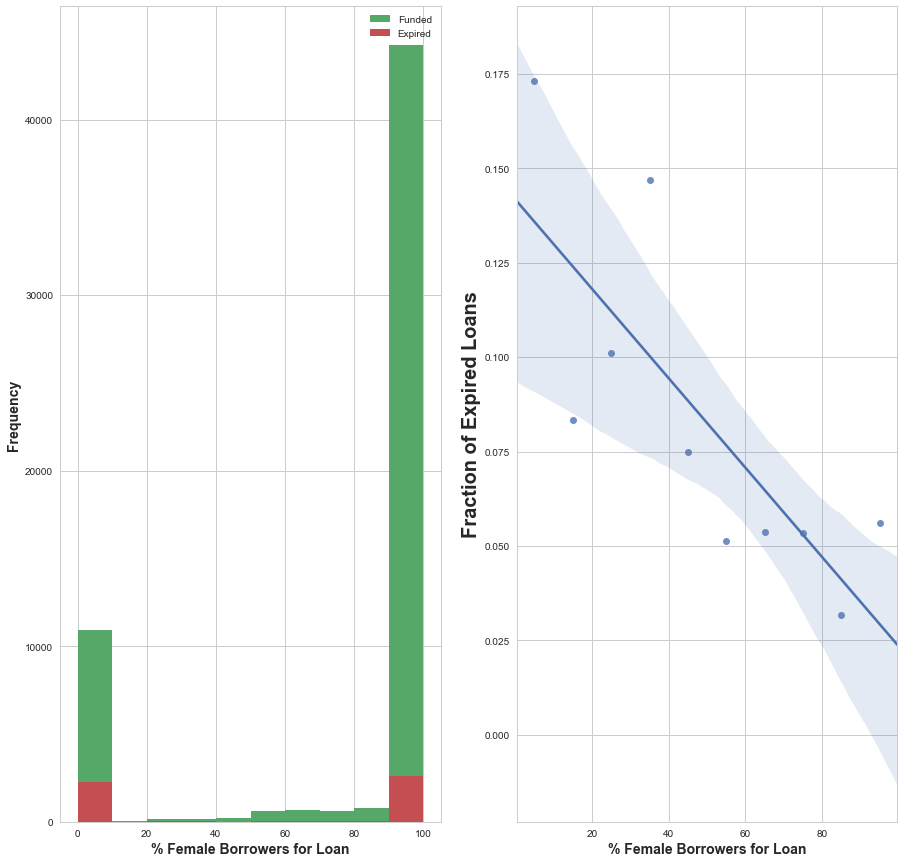

In [109]:
plot_expiration_rate_by_feature('percentage_women', '% Female Borrowers for Loan', (0,100))

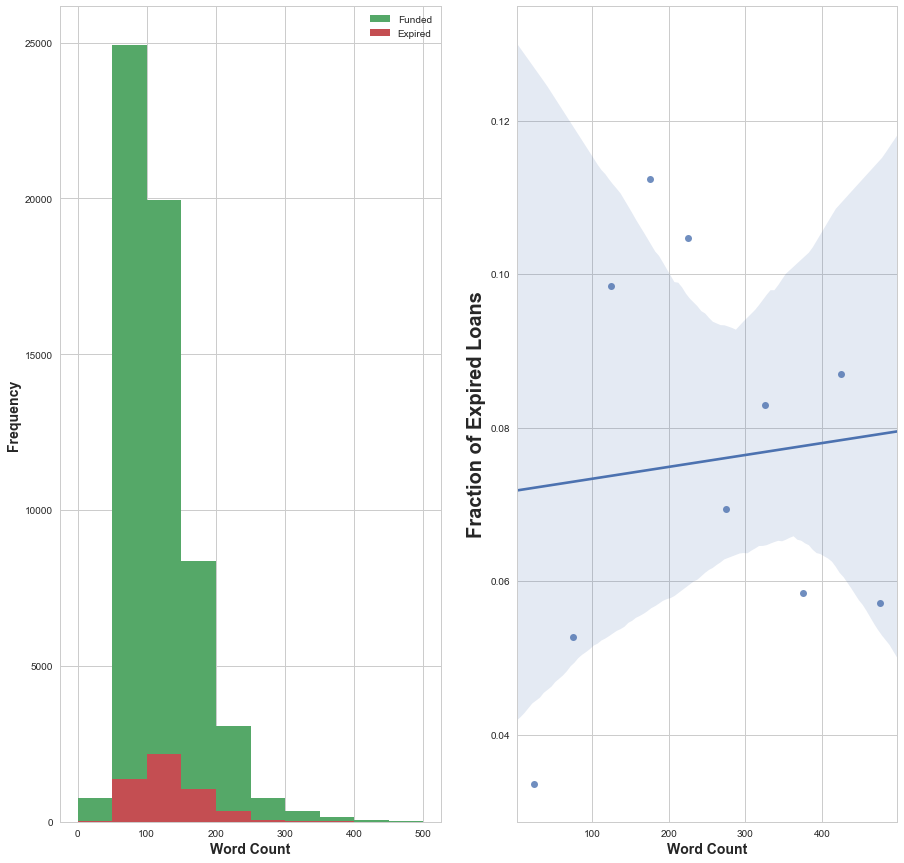

In [110]:
plot_expiration_rate_by_feature('description_word_count', 'Word Count', (0, 500))

## Helper Functions

In [111]:
def order_zip_coeff(coeff_names, coeff_vals):
    coeff_names = np.array(coeff_names)
    coeff_vals = np.array(coeff_vals)
    importance_indices = np.argsort(coeff_vals)[::-1]
    return list(enumerate(zip(coeff_names[importance_indices], coeff_vals[importance_indices])))


def cross_val_predict_proba(model, X, y, folds=5, verbose=True):
    """
    Function like “cross_val_predict” except using `predict_proba`. 
    May be useful to do cross-validation or grid-search, but using ROC_AUC 
    instead of accuracy or some other metric.
    
    Returns y_proba based on cross_validated train set
    """
    this_model = clone(model)
    num_classes = len(np.unique(y))
    y_pred = np.zeros((len(y),num_classes))
    skf = StratifiedKFold(n_splits=folds, shuffle=True).split(X, y)
    for idx, (train_idx, test_idx) in enumerate(skf):
        if verbose:
            print("training fold {} of {}".format(idx+1, folds))
        X_train = np.array(X)[train_idx,:]
        X_test = np.array(X)[test_idx,:]
        y_train = np.array(y)[train_idx]        
        this_model.fit(X_train,y_train)
        y_pred[test_idx,:] = this_model.predict_proba(X_test)
    return y_pred

def metric_curves(truthvec, scorevec, digit_prec=2):
    """
    Draw multiple metric curves on same graph
    
    truthvec = y_actual_test, 
    scorevec = y_pred_proba
    """
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)
    
    accuracyvec = np.zeros(numthresh)
    
    for i in range(numthresh):
        thresh = threshvec[i]
        pos_pred = (scorevec >= thresh)
        neg_pred = (scorevec < thresh)
        tpvec[i] = sum(truthvec[pos_pred])
        fpvec[i] = sum(1 - truthvec[pos_pred])
        fnvec[i] = sum(truthvec[neg_pred])
        
        # prediction changes with every threshold
        predvec = [1 if pred_pos else 0 for pred_pos in pos_pred]
        accuracyvec[i] = accuracy_score(truthvec, predvec)
        
    recallvec = tpvec / (tpvec + fnvec)
    precisionvec = tpvec / (tpvec + fpvec)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Precision vs Thresholds and Recall vs Thresholds
    ax.plot(threshvec, precisionvec, label='Precision')
    ax.plot(threshvec, recallvec, label='Recall')
    ax.plot(threshvec, accuracyvec, label='Accuracy')

    ax.axis([0, 1, 0, 1])
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Precision / Recall / Accuracy")
    ax.legend()
    
    return (recallvec, precisionvec, threshvec)

def print_metrics(model_name, y_actual_test, y_pred_proba):
    auc_score = roc_auc_score(y_actual_test, y_pred_proba)
    l_loss = log_loss(y_actual_test, y_pred_proba)
    print('--- ', model_name, ' ---')
    print('AUC: ', auc_score)
    print('Log Loss: ', l_loss)
    recallvec, precisionvec, threshvec = metric_curves(y_actual_test, y_pred_proba, digit_prec=2)
    return (recallvec, precisionvec, threshvec, auc_score, l_loss)
    

In [112]:
def example_calc():
    pos_pred = np.array([True, False, True, False])
    truthvec = np.array([1, 0, 0, 1])
    tpvec = truthvec[pos_pred]
    fpvec = 1 - tpvec
    
    neg_pred = np.array([False, True, False, True]) # Opposite
    fnvec = truthvec[neg_pred]
    print('Predicted positives (Indices 0, 2):', tpvec, ', Actual Pos (Indice 0), ', 'True Pos Count: ', sum(tpvec))
    print('False positives: ', fpvec, '(Indice 2), False Pos Count: ', sum(fpvec))
    print('False negatives: ', fnvec, '(Indices 1, 3), False Neg Count: ', sum(fnvec))
example_calc()    

Predicted positives (Indices 0, 2): [1 0] , Actual Pos (Indice 0),  True Pos Count:  1
False positives:  [0 1] (Indice 2), False Pos Count:  1
False negatives:  [0 1] (Indices 1, 3), False Neg Count:  1


## k-NN
Use k-NN as a feature input to another model to capture interaction effects. k-NN suffers heavily from curse of dimensionality so only use 3 features.

Fitted k=70, Log Loss: 0.24767204657624742
Fitted k=72, Log Loss: 0.24239405025228458
Fitted k=74, Log Loss: 0.2437145611960853
Fitted k=76, Log Loss: 0.2406263099881281
Fitted k=78, Log Loss: 0.24674966856265834
Fitted k=80, Log Loss: 0.24071256819282422
Fitted k=82, Log Loss: 0.22983927365871407
Fitted k=84, Log Loss: 0.23447872738169012
Fitted k=86, Log Loss: 0.23750036809117317
Fitted k=88, Log Loss: 0.23168277335714196
Fitted k=90, Log Loss: 0.23431963400343295
Fitted k=92, Log Loss: 0.22835810741986268
Fitted k=94, Log Loss: 0.23713770000361106
Fitted k=96, Log Loss: 0.2241628924655147
Fitted k=98, Log Loss: 0.23438658641372737
Fitted k=100, Log Loss: 0.22502861908577515
Fitted k=102, Log Loss: 0.23599350108983363
Fitted k=104, Log Loss: 0.22858972856910764
Fitted k=106, Log Loss: 0.22967867710189635
Fitted k=108, Log Loss: 0.23015340530858086
Fitted k=110, Log Loss: 0.2245185756667656
Fitted k=112, Log Loss: 0.22718116579573666
Fitted k=114, Log Loss: 0.23082799026553483
Fitted 

[(118, 0.22026777983159737),
 (96, 0.22416289246551471),
 (110, 0.22451857566676561),
 (100, 0.22502861908577515),
 (112, 0.22718116579573666),
 (92, 0.22835810741986268),
 (104, 0.22858972856910764),
 (106, 0.22967867710189635),
 (82, 0.22983927365871407),
 (108, 0.23015340530858086)]

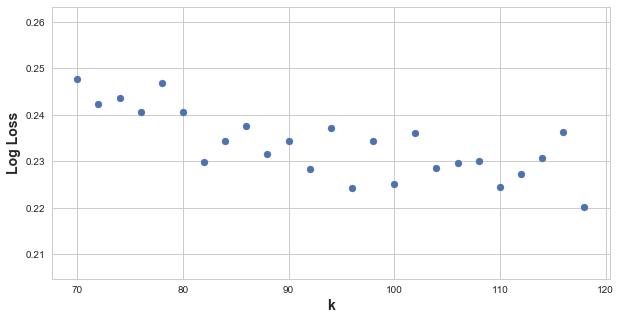

In [113]:
knn_cols = ['loan_amount',  'latitude', 'longitude']
std_knn = StandardScaler()
std_knn.fit(X_train.loc[:, knn_cols])

X_std_train_knn = std_knn.transform(X_train.loc[:, knn_cols])
X_std_test_knn = std_knn.transform(X_test.loc[:, knn_cols])

def plot_k_vs_logloss():
    """See which value of `k` givest the lowest log loss"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 
    knn_log_loss_scores = []
    k_range = range(70, 120, 2)
    for k in k_range:
        knn_model_k = KNeighborsClassifier(n_neighbors=k)
        y_cross_val_pred_proba_knn = cross_val_predict_proba(knn_model_k, X_std_train_knn, y_train, verbose=False)[:, 1]
        k_log_loss = log_loss(y_train, y_cross_val_pred_proba_knn)
        print('Fitted k={}, Log Loss: {}'.format(k, k_log_loss))
        knn_log_loss_scores.append((k, k_log_loss))

    ax.scatter(k_range, [log_loss for knn, log_loss in knn_log_loss_scores])
    ax.set_xlabel('k')
    ax.set_ylabel('Log Loss')
    knn_log_loss_scores.sort(key=lambda x: x[1], reverse=False)
    return knn_log_loss_scores[:10]

plot_k_vs_logloss()

---  KNN, K=98  ---
AUC:  0.841402035085
Log Loss:  0.230180068858


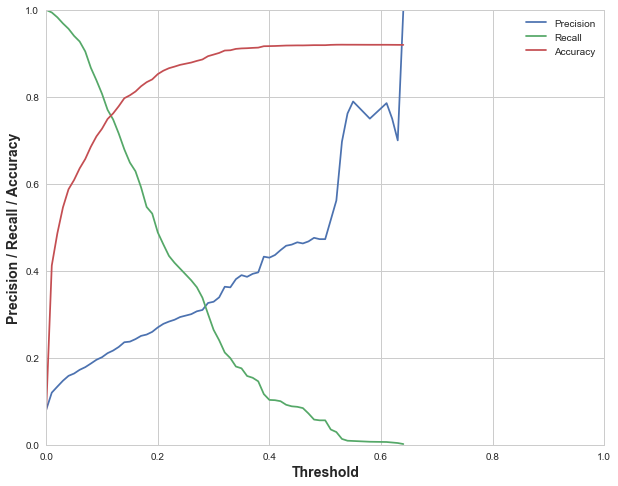

In [114]:
k_final = 98
knn_model = KNeighborsClassifier(n_neighbors=k_final)
knn_model.fit(X_std_train_knn, y_train)
y_test_pred_proba_knn = knn_model.predict_proba(X_std_test_knn)[:, 1]

model_name_knn = 'KNN, K={}'.format(k_final)
recallvec_knn, precisionvec_knn, threshvec_knn, auc_score_knn, l_loss_knn = print_metrics (
    model_name_knn, y_test, y_test_pred_proba_knn)

### Use k-NN Probability Prediction as a Feature

In [115]:
y_train_pred_proba_knn = knn_model.predict_proba(X_std_train_knn)[:, 1]

# Add new column `knn_pred`
X_train['knn_pred'] = y_train_pred_proba_knn
X_test['knn_pred'] = y_test_pred_proba_knn

## Random Forest

---  Random Forest  ---
AUC:  0.90153005158
Log Loss:  0.195713183012


/Users/nanawu/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


[(0, ('description_word_count', 0.2201335179490127)),
 (1, ('knn_pred', 0.155781939905063)),
 (2, ('loan_amount', 0.10878655184840001)),
 (3, ('tag_max_idf', 0.10347364396454531)),
 (4, ('terms_repayment_term', 0.09517119819923027)),
 (5, ('tag_min_idf', 0.051858393044138661)),
 (6, ('activity_percent_expired', 0.041660329334555622)),
 (7, ('sector_percent_expired', 0.041434406208451818)),
 (8, ('longitude', 0.037976834664438096)),
 (9, ('latitude', 0.037733545892876509)),
 (10, ('country_percent_expired', 0.037457073019116514)),
 (11, ('percentage_women', 0.031955582644923063)),
 (12, ('country_total_loans', 0.02428708143962513)),
 (13, ('borrower_count', 0.012289901885623544))]

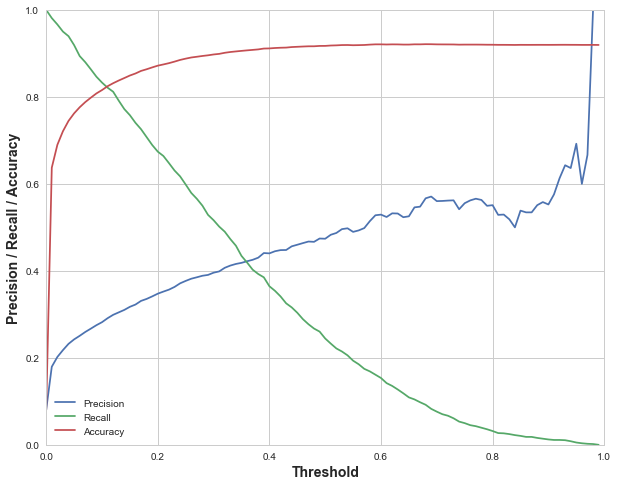

In [116]:
rf_cols =  ['loan_amount',  'latitude', 'longitude',
            'borrower_count', 'percentage_women', 
            'sector_percent_expired', 'activity_percent_expired',
            'country_percent_expired', 'country_total_loans', 
            'terms_repayment_term', 'tag_max_idf', 'tag_min_idf', 
            'description_word_count', 'knn_pred']
        
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model.fit(X_train.loc[:, rf_cols], y_train)

# predict class labels for the test set
y_test_pred_proba_rf = rf_model.predict_proba(X_test.loc[:, rf_cols])[:, 1]

model_name_rf = 'Random Forest'
recallvec_rf, precisionvec_rf, threshvec_rf, auc_score_rf, l_loss_rf = print_metrics(
    model_name_rf, y_test, y_test_pred_proba_rf)

order_zip_coeff(rf_cols, rf_model.feature_importances_)

## Gradient Boosting Classifier

---  Gradient Boosting Classifier  ---
AUC:  0.907712831876
Log Loss:  0.18417904712


[(0, ('loan_amount', 0.20270440113919533)),
 (1, ('terms_repayment_term', 0.15222949453197854)),
 (2, ('sector_percent_expired', 0.11282271444898667)),
 (3, ('country_percent_expired', 0.11075712546252975)),
 (4, ('country_total_loans', 0.093009764158730177)),
 (5, ('tag_max_idf', 0.081802149103540764)),
 (6, ('description_word_count', 0.053084410506032596)),
 (7, ('tag_min_idf', 0.050294584844411058)),
 (8, ('percentage_women', 0.048754378969684896)),
 (9, ('longitude', 0.047374504836300631)),
 (10, ('latitude', 0.042452641816346393)),
 (11, ('borrower_count', 0.0047138301822631859))]

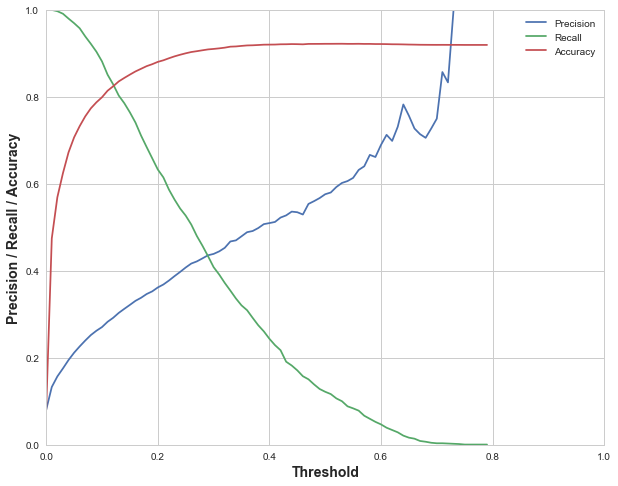

In [117]:
gb_cols =  ['loan_amount',  'latitude', 'longitude',
            'borrower_count', 'percentage_women', 
            'sector_percent_expired', 
            'country_percent_expired', 'country_total_loans', 
            'terms_repayment_term', 'tag_max_idf', 'tag_min_idf', 'description_word_count']

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train.loc[:, gb_cols], y_train)
y_test_pred_proba_gb = gb_model.predict_proba(X_test.loc[:, gb_cols])[:, 1]

model_name_gb = 'Gradient Boosting Classifier'
recallvec_gb, precisionvec_gb, threshvec_gb, auc_score_gb, l_loss_gb = print_metrics (
    model_name_gb, y_test, y_test_pred_proba_gb)

order_zip_coeff(gb_cols, gb_model.feature_importances_)

## Logistic Regression

---  Logistic Regression  ---
AUC:  0.862114178295
Log Loss:  0.21743350074


[(0, ('knn_pred', 0.88083258070841186)),
 (1, ('sector_percent_expired', 0.4114321923012752)),
 (2, ('terms_repayment_term', 0.20067116310752489)),
 (3, ('loan_amount', 0.073655747385030487)),
 (4, ('description_word_count', -0.11284077328851529)),
 (5, ('tag_max_idf', -0.13138086682162819)),
 (6, ('tag_min_idf', -0.27867231933981551)),
 (7, ('percentage_women', -0.35217248264762713))]

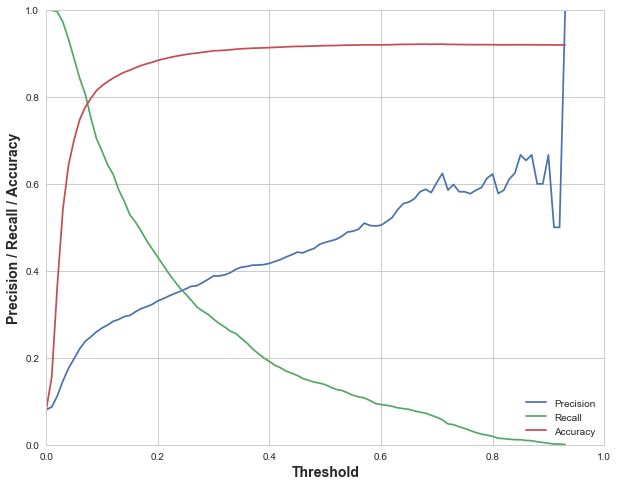

In [118]:
lr_cols = ['loan_amount', 'percentage_women',
           'knn_pred', 'sector_percent_expired',
           'terms_repayment_term', 
           'tag_max_idf', 'tag_min_idf', 'description_word_count']

std_lr = StandardScaler()
std_lr.fit(X_train.loc[:, lr_cols])

X_std_train_lr = std_lr.transform(X_train.loc[:, lr_cols])
X_std_test_lr = std_lr.transform(X_test.loc[:, lr_cols])

lr_model = LogisticRegression()
lr_model.fit(X_std_train_lr, y_train)
y_test_pred_proba_lr = lr_model.predict_proba(X_std_test_lr)[:, 1]

model_name_lr = 'Logistic Regression'
recallvec_lr, precisionvec_lr, threshvec_lr, auc_score_lr, l_loss_lr = print_metrics (
    model_name_lr, y_test, y_test_pred_proba_lr)

order_zip_coeff(lr_cols, lr_model.coef_[0])



## Ensemble Method

---  Ensemble  ---
AUC:  0.898277080452
Log Loss:  0.194295284537


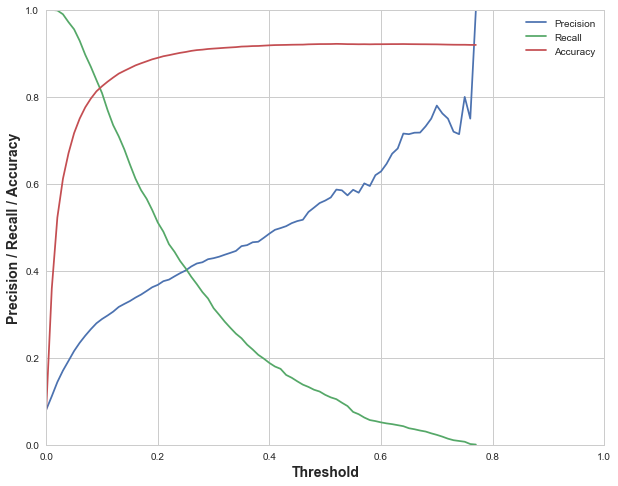

In [119]:
y_test_pred_proba_ensemble = (y_test_pred_proba_lr * y_test_pred_proba_gb)**(.5)

model_name_ensemble = 'Ensemble'
recallvec_ensemble, precisionvec_ensemble, threshvec_ensemble, auc_score_ensemble, l_loss_ensemble = print_metrics (
    model_name_ensemble, y_test, y_test_pred_proba_ensemble)

## Metrics

In [120]:
# Baseline Metrics
percentage_pos = np.mean(y_train)
percentage_neg = 1 - percentage_pos
baseline_logloss = -1 * ((percentage_pos * np.log(percentage_pos)) + ((1-percentage_neg) * np.log(percentage_neg)))
# starting from low entropy
print('Positive: {}%, Baseline Log Loss: {}'.format(percentage_pos * 100, baseline_logloss))

Positive: 8.053374455161997%, Baseline Log Loss: 0.20963263330049575


### Model Comparisons

,Model,Log Loss,Log Loss / Baseline Log Loss,AUC
0,Baseline,0.209633,1.000000,NaN
1,Gradient Boosting Classifier,0.184179,0.878580,0.907713
2,Random Forest,0.195713,0.933601,0.901530
3,Logistic Regression,0.217434,1.037212,0.862114


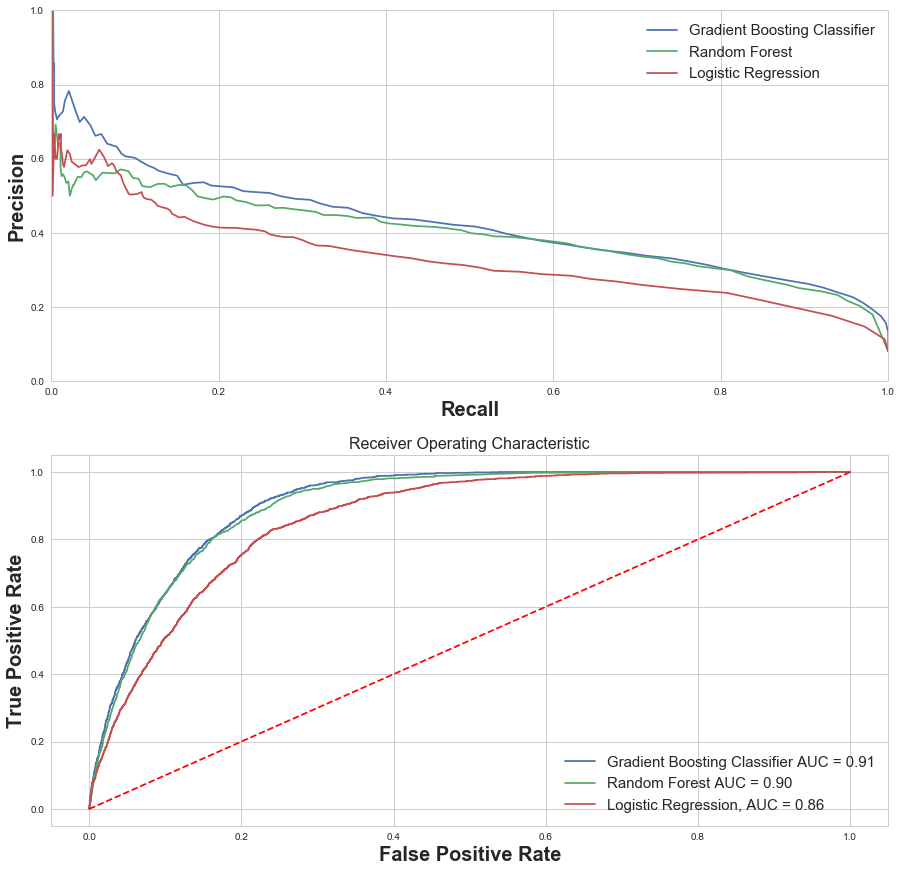

In [121]:
# ROC Curve
fpr_gb, tpr_gb, threshold_gb = roc_curve(y_test, y_test_pred_proba_gb)
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, y_test_pred_proba_rf)
fpr_knn, tpr_knn, threshold_knn = roc_curve(y_test, y_test_pred_proba_knn)
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, y_test_pred_proba_lr)
fpr_ensemble, tpr_ensemble, threshold_ensemble = roc_curve(y_test, y_test_pred_proba_ensemble)

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

# Precision Recall
ax[0].plot(recallvec_gb, precisionvec_gb, label=model_name_gb)
ax[0].plot(recallvec_rf, precisionvec_rf, label=model_name_rf)
ax[0].plot(recallvec_lr, precisionvec_lr, label=model_name_lr)

ax[0].axis([0, 1, 0, 1])
ax[0].set_ylabel("Precision", fontsize=20)
ax[0].set_xlabel("Recall", fontsize=20)
ax[0].legend(prop={'size': 15})

# ROC Curve
ax[1].set_title('Receiver Operating Characteristic')
ax[1].plot(fpr_gb, tpr_gb, label = 'Gradient Boosting Classifier AUC = %0.2f' % auc_score_gb)
ax[1].plot(fpr_rf, tpr_rf, label = 'Random Forest AUC = %0.2f' % auc_score_rf)
ax[1].plot(fpr_lr, tpr_lr, label = 'Logistic Regression, AUC = %0.2f' % auc_score_lr)

ax[1].legend(loc = 'lower right', prop={'size': 15})
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_ylabel('True Positive Rate', fontsize=20)
ax[1].set_xlabel('False Positive Rate', fontsize=20)

# Other Metrics:
df_metrics = pd.DataFrame({'Model': ['Baseline', model_name_gb, model_name_rf, 
                                     model_name_lr],
                           'Log Loss': [baseline_logloss, l_loss_gb, l_loss_rf, 
                                        l_loss_lr],
                           'Log Loss / Baseline Log Loss': [
                               1, (l_loss_gb / baseline_logloss),
                               (l_loss_rf / baseline_logloss), (l_loss_lr / baseline_logloss),],
                           'AUC': [np.nan, auc_score_gb, auc_score_rf, auc_score_lr]})
df_metrics[['Model', 'Log Loss', 'Log Loss / Baseline Log Loss', 'AUC']]

In [122]:
df[df.status == 'expired']['id'].map(lambda loan_id: 'https://www.kiva.org/lend/' + str(loan_id))[:5]

276    https://www.kiva.org/lend/1033039
378    https://www.kiva.org/lend/1033678
389    https://www.kiva.org/lend/1034035
502    https://www.kiva.org/lend/1034584
504    https://www.kiva.org/lend/1034593
Name: id, dtype: object